In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 6)
# we use regex here to parse the output log files
import re

Populating the interactive namespace from numpy and matplotlib


# Processing Results without Worker Failures

In [36]:
import numpy as np
method = ['traditional', 'geo_median', 'maj_vote']
acc_stat = []
step_list = [i for i in range(0, 10001, 50)]
# parse acc log files first
for m in method:
    _tmp_acc = []
    with open('./no_fail/'+m+'_case') as acc_file:
        for line in acc_file.readlines():
            line_string = line.rstrip('\n')
            search_sth = re.match('Test set: Average loss: .*, Prec@1: (.*) Prec@5: (.*)', line_string)
            if search_sth:
                acc = float(search_sth.group(1))
                _tmp_acc.append(acc)
        # we only want data from the first 10000 iterations
        acc_stat.append(_tmp_acc[0:200])
        
# then we get the time cost
stats = []
for i,m in enumerate(method):
    stat_dict_worker = {}
    stat_dict_master = {}
    print("Start Processing {}".format(m))
    with open('./no_fail/no_fail_'+m, 'rb') as worker_file:
        for line in worker_file.readlines():
            line_string = line.rstrip('\n')
            #print(line_string)
            search_sth_worker = re.match('Worker: (.*), Cur Step: (.*), Train Epoch: .* \[.*/.* \(.*%\)\], Train Loss: .*, Time Cost: (.*), Computation Time: .*, Prec@1: .*, Prec@5: .*', line_string)
            master_search_sth =re.match('Master Step: (.*), Method Time Cost: (.*), Update Time Cost: (.*)', line_string)
            # processing worker content
            if search_sth_worker:
                worker_id, cur_step_worker, time_cost = search_sth_worker.group(1), int(search_sth_worker.group(2)), float(search_sth_worker.group(3))
                if cur_step_worker <= 10000:
                    if cur_step_worker not in stat_dict_worker.keys():
                        stat_dict_worker[cur_step_worker] = [time_cost]
                    else:
                        stat_dict_worker[cur_step_worker].append(time_cost)
            # processing master content
            if master_search_sth:
                try:
                    cur_step_master, method_time_cost, update_time_cost = int(master_search_sth.group(1)),float(master_search_sth.group(2)),float(master_search_sth.group(3))
                except ValueError:
                    print(cur_step_master, master_search_sth.group(0))
                    print("======================================================================")
                if cur_step_master <= 10000:
                    if cur_step_master not in stat_dict_master.keys():
                        stat_dict_master[cur_step_master] = [method_time_cost, update_time_cost]
        # sanity check here:
        if len(stat_dict_worker.keys()) != len(stat_dict_master.keys()):
            for k in stat_dict_worker.keys():
                if k not in stat_dict_master.keys():
                    print("Key {} Messed Up!".format(k))
        assert len(stat_dict_worker.keys()) == len(stat_dict_master.keys())
        stats.append([stat_dict_master, stat_dict_worker])
    print("Done Processing {}".format(m))    

Start Processing traditional
Done Processing traditional
Start Processing geo_median
Done Processing geo_median
Start Processing maj_vote
Done Processing maj_vote


In [37]:
# processing results
time_lines = []
for dict_pair in stats:
    _tmp_time_costs = []
    _time_counter = 0
    m_dict = dict_pair[0]
    w_dict = dict_pair[1]
    for i, (k, v) in enumerate(w_dict.iteritems()):
        _time_counter += max(v)
        _time_counter += m_dict[k][0]
        _time_counter += m_dict[k][1]
        if i % 50 == 0:
            _tmp_time_costs.append(_time_counter)
    time_lines.append(_tmp_time_costs)

# No Worker Failure

Total Time Cost of Traditional Method: 15287.3285529
Total Time Cost of Majority Vote Method: 17044.3683378
Total Time Cost of Geometric Median Method: 40353.6963073


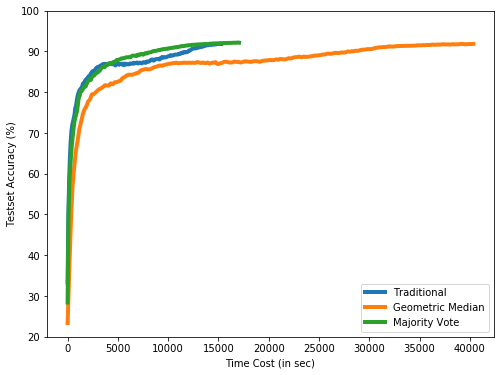

In [41]:
print("Total Time Cost of Traditional Method: {}".format(time_lines[0][-1]))
print("Total Time Cost of Majority Vote Method: {}".format(time_lines[2][-1]))
print("Total Time Cost of Geometric Median Method: {}".format(time_lines[1][-1]))
fig = plt.figure()
ax=plt.subplot(111)
plt.plot(time_lines[0], acc_stat[0],'-', linewidth=4.0,  label='Traditional')
plt.plot(time_lines[1], acc_stat[1],'-', linewidth=4.0,  label='Geometric Median')
plt.plot(time_lines[2], acc_stat[2], '-',linewidth=4.0,  label='Majority Vote')
plt.xlabel("Time Cost (in sec)")
plt.ylabel("Testset Accuracy (%)")
ax.set_ylim(20, 100)
plt.legend()
plt.show()

# Processing Results of Reversed Gradients Worker Failure

In [42]:
method = ['traditional','geo_median', 'maj_vote']
num_failure = ['15', '21']
acc_stat = [{},{},{}]
step_list = [i for i in range(0, 10001, 50)]
# parse acc log files first
for i,m in enumerate(method):
    for f in num_failure:
        _tmp_acc = []
        with open('./rev_grad/'+m+'_fail'+f+'_case') as acc_file:
            for line in acc_file.readlines():
                line_string = line.rstrip('\n')
                search_sth = re.match('Test set: Average loss: .*, Prec@1: (.*) Prec@5: (.*)', line_string)
                if search_sth:
                    acc = float(search_sth.group(1))
                    _tmp_acc.append(acc)
            # we only want data from the first 10000 iterations
            acc_stat[i][f]=_tmp_acc[0:200]
print(len(acc_stat[0]['15']))
print(len(acc_stat[0]['21']))
print(len(acc_stat[1]['15']))
print(len(acc_stat[1]['21']))
print(len(acc_stat[2]['15']))
print(len(acc_stat[2]['21']))


# then we get the time cost
stats = [{},{},{}]
for i,m in enumerate(method):
    for f in num_failure:
        stat_dict_worker = {}
        stat_dict_master = {}
        print("Start Processing {}".format(m))
        with open('./rev_grad/fail_'+f+'_rev_grad_'+m, 'rb') as worker_file:
            for line in worker_file.readlines():
                line_string = line.rstrip('\n')
                search_sth_worker = re.match('Worker: (.*), Cur Step: (.*), Train Epoch: .* \[.*/.* \(.*%\)\], Train Loss: .*, Time Cost: (.*), Computation Time: .*, Prec@1: .*, Prec@5: .*', line_string)
                master_search_sth =re.match('Master Step: (.*), Method Time Cost: (.*), Update Time Cost: (.*)', line_string)
                # processing worker content
                if search_sth_worker:
                    worker_id, cur_step_worker, time_cost = search_sth_worker.group(1), int(search_sth_worker.group(2)), float(search_sth_worker.group(3))
                    if cur_step_worker <= 10000:
                        if cur_step_worker not in stat_dict_worker.keys():
                            stat_dict_worker[cur_step_worker] = [time_cost]
                        else:
                            stat_dict_worker[cur_step_worker].append(time_cost)
                # processing master content
                if master_search_sth:
                    try:
                        cur_step_master, method_time_cost, update_time_cost = int(master_search_sth.group(1)),float(master_search_sth.group(2)),float(master_search_sth.group(3))
                    except ValueError:
                        print(cur_step_master, master_search_sth.group(0))
                        print("======================================================================")
                    if cur_step_master <= 10000:
                        if cur_step_master not in stat_dict_master.keys():
                            stat_dict_master[cur_step_master] = [method_time_cost, update_time_cost]
            # sanity check here:
            if len(stat_dict_worker.keys()) != len(stat_dict_master.keys()):
                for k in stat_dict_worker.keys():
                    if k not in stat_dict_master.keys():
                        print("Key {} Messed Up!".format(k))
            assert len(stat_dict_worker.keys()) == len(stat_dict_master.keys())
            stats[i][f] = [stat_dict_master, stat_dict_worker]
        print("Done Processing {}".format(m))

200
200
200
200
200
200
Start Processing traditional
Done Processing traditional
Start Processing traditional
Done Processing traditional
Start Processing geo_median
Done Processing geo_median
Start Processing geo_median
Done Processing geo_median
Start Processing maj_vote
Done Processing maj_vote
Start Processing maj_vote
Done Processing maj_vote


In [43]:
# processing results
time_lines = [{},{},{}]
#for k,v in stats[0]['15'][1].iteritems():
#    print(v)
for t, dict_pairs in enumerate(stats):
    for f in num_failure:
        _tmp_time_costs = []
        _time_counter = 0
        m_dict = dict_pairs[f][0]
        w_dict = dict_pairs[f][1]
        for i, (k, v) in enumerate(w_dict.iteritems()):
            _time_counter += max(v)
            _time_counter += m_dict[k][0]
            _time_counter += m_dict[k][1]
            if i % 50 == 0:
                _tmp_time_costs.append(_time_counter)
        time_lines[t][f]=_tmp_time_costs

# Reversed Gradient Worker Failure

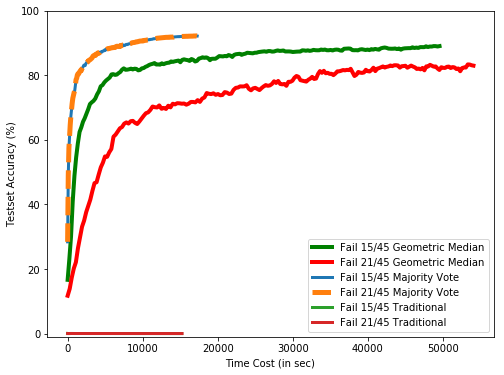

In [45]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(time_lines[1]['15'], acc_stat[1]['15'],'-g', linewidth=4.0,  label='Fail 15/45 Geometric Median')
plt.plot(time_lines[1]['21'], acc_stat[1]['21'],'-r', linewidth=4.0,  label='Fail 21/45 Geometric Median')
plt.plot(time_lines[2]['21'], acc_stat[2]['21'], '-',linewidth=3.0,  label='Fail 15/45 Majority Vote')
plt.plot(time_lines[2]['15'], acc_stat[2]['15'], '--',linewidth=5.0,  label='Fail 21/45 Majority Vote')
plt.plot(time_lines[0]['15'], acc_stat[0]['15'],'-', linewidth=3.0,  label='Fail 15/45 Traditional')
plt.plot(time_lines[0]['21'], acc_stat[0]['21'],'-', linewidth=3.0,  label='Fail 21/45 Traditional')
ax.set_ylim(-1, 100)
plt.xlabel("Time Cost (in sec)")
plt.ylabel("Testset Accuracy (%)")
plt.legend()
plt.show()

# Processing Results of Constant Err Worker Failure

In [51]:
method = ['geo_median', 'maj_vote']
num_failure = ['15']
acc_stat = [{},{}]
step_list = [i for i in range(0, 10001, 50)]
# parse acc log files first
for i,m in enumerate(method):
    for f in num_failure:
        _tmp_acc = []
        with open('./const_grad/'+'fail'+f+'_'+m+'_acc') as acc_file:
            for line in acc_file.readlines():
                line_string = line.rstrip('\n')
                search_sth = re.match('Test set: Average loss: .*, Prec@1: (.*) Prec@5: (.*)', line_string)
                if search_sth:
                    acc = float(search_sth.group(1))
                    _tmp_acc.append(acc)
            # we only want data from the first 10000 iterations
            acc_stat[i][f]=_tmp_acc[0:200]
print(len(acc_stat[0]['15']))
print(len(acc_stat[1]['15']))

# then we get the time cost
stats = [{},{}]
for i,m in enumerate(method):
    for f in num_failure:
        stat_dict_worker = {}
        stat_dict_master = {}
        print("Start Processing {}".format(m))
        with open('./const_grad/fail_'+f+'_'+m+'_const', 'rb') as worker_file:
            for line in worker_file.readlines():
                line_string = line.rstrip('\n')
                search_sth_worker = re.match('Worker: (.*), Cur Step: (.*), Train Epoch: .* \[.*/.* \(.*%\)\], Train Loss: .*, Time Cost: (.*), Computation Time: .*, Prec@1: .*, Prec@5: .*', line_string)
                master_search_sth =re.match('Master Step: (.*), Method Time Cost: (.*), Update Time Cost: (.*)', line_string)
                # processing worker content
                if search_sth_worker:
                    worker_id, cur_step_worker, time_cost = search_sth_worker.group(1), int(search_sth_worker.group(2)), float(search_sth_worker.group(3))
                    if cur_step_worker <= 10000:
                        if cur_step_worker not in stat_dict_worker.keys():
                            stat_dict_worker[cur_step_worker] = [time_cost]
                        else:
                            stat_dict_worker[cur_step_worker].append(time_cost)
                # processing master content
                if master_search_sth:
                    try:
                        cur_step_master, method_time_cost, update_time_cost = int(master_search_sth.group(1)),float(master_search_sth.group(2)),float(master_search_sth.group(3))
                    except ValueError:
                        print(cur_step_master, master_search_sth.group(0))
                        print("======================================================================")
                    if cur_step_master <= 10000:
                        if cur_step_master not in stat_dict_master.keys():
                            stat_dict_master[cur_step_master] = [method_time_cost, update_time_cost]
            # sanity check here:
            if len(stat_dict_worker.keys()) != len(stat_dict_master.keys()):
                for k in stat_dict_worker.keys():
                    if k not in stat_dict_master.keys():
                        print("Key {} Messed Up!".format(k))
            assert len(stat_dict_worker.keys()) == len(stat_dict_master.keys())
            stats[i][f] = [stat_dict_master, stat_dict_worker]
        print("Done Processing {}".format(m))

200
200
Start Processing geo_median
Done Processing geo_median
Start Processing maj_vote
Done Processing maj_vote


In [52]:
# processing results
time_lines = [{},{}]
for t, dict_pairs in enumerate(stats):
    for f in num_failure:
        _tmp_time_costs = []
        _time_counter = 0
        m_dict = dict_pairs[f][0]
        w_dict = dict_pairs[f][1]
        for i, (k, v) in enumerate(w_dict.iteritems()):
            _time_counter += max(v)
            _time_counter += m_dict[k][0]
            _time_counter += m_dict[k][1]
            if i % 50 == 0:
                _tmp_time_costs.append(_time_counter)
        time_lines[t][f]=_tmp_time_costs

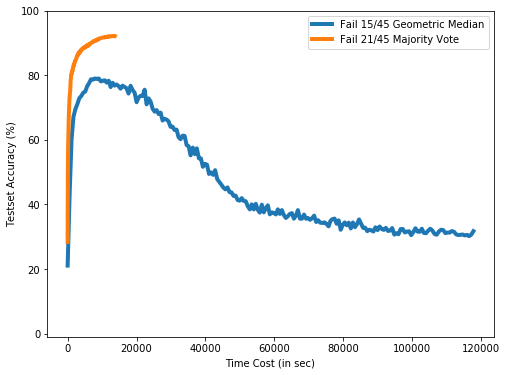

In [54]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(time_lines[0]['15'], acc_stat[0]['15'],'-', linewidth=4.0,  label='Fail 15/45 Geometric Median')
plt.plot(time_lines[1]['15'], acc_stat[1]['15'],'-', linewidth=4.0,  label='Fail 21/45 Majority Vote')
ax.set_ylim(-1, 100)
plt.xlabel("Time Cost (in sec)")
plt.ylabel("Testset Accuracy (%)")
plt.legend()
plt.show()